# Th analysis, October 2017

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   mpl_toolkits.mplot3d                    import Axes3D

## Function definitions

In [2]:
def gaussexpo(x, amp, mu, sigma, const, mean, x0):

    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.) + const * np.exp((x-x0)/mean)

# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def reso_errors(values,errors):
    _, mu, sigma = values
    _, err_mu, err_sigma = errors
    r = 235. * sigma/mu
    err_r = r*np.sqrt((err_sigma/sigma)**2 + (err_mu/mu)**2)
    return err_r, err_r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values)))

def gaussexpotext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        $\\bar x$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:3], values[4], *reso(values[0:3])))

## Read the corrections table

In [3]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/run4628_corrections_5.3mm.h5"
fcorr     = dstf.load_xy_corrections(corr_file)

-------------------------

# Read in the output of Penthesilea 
## (NOTE: these steps do not need to be run if the data arrays have already been constructed and saved; in this case skip to "Save/load main event quantities")
Reads in Penthesilea output from the runs listed

In [ ]:
def merge_NN_hits(hits_all,hits_nonNN):

    # Iterate through the nonNN dictionary and update the energies including the NN hits from the "all" dictionary.
    for (evt,hc) in hits_nonNN.items():

        # Get the corresponding collection of all hits.
        hc_all = hits_all[evt]
            
        # Add energy from all NN hits to hits in closest slice.
        for h1 in hc_all.hits:

            if(h1.Q == NN):

                # Find the hits to which the energy will be added.
                zdist_min = -1
                h_add = []
                for h2 in hc.hits:
                    zdist = np.abs(h1.Z - h2.Z)
                    if(zdist_min < 0 or zdist < zdist_min):
                        zdist_min = zdist
                        h_add = []
                        h_add.append(h2)
                    elif(zdist == zdist_min):
                        h_add.append(h2)

                # Add the energy.
                hadd_etot = sum([ha.E for ha in h_add])
                for ha in h_add:
                    ha.energy += h1.E*(ha.E/hadd_etot)
                    
        # Check the sum of the energy.
        #e1 = sum([hh.E for hh in hc_all.hits])
        #e2 = sum([hh.E for hh in hc.hits])
        #if(abs(e1 - e2) > 0.001):
        #    print("ERROR")


In [ ]:
# run numbers and lifetime values for correction
#l_rnum   = [4717, 4718, 4719, 4720]
l_rnum   = [4720]
#l_tlife  = [1598, 1598, 1598, 1598]
l_tlife = [1598]
l_nfiles = [2774]
#l_nfiles = [596, 6054, 114, 2774]


In [ ]:
l_hitc = []; l_tlife_hitc = []
for rnum,tlife,nfile in zip(l_rnum,l_tlife,l_nfiles):
    
    print("Loading hits from {0} files of run {1}".format(nfile,rnum))
    
    for rr in range(nfile):
        
        # Fill run number with zeros if necessary.
        rstr = rr
        if(rr < 10):
            rstr = '00{0}'.format(rstr)
        elif(rr < 100):
            rstr = '0{0}'.format(rstr)
        
        fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks.gdcsnext.{1}_{2}.root.h5".format(rnum,rstr,rnum)
        if(os.path.isfile(fname)):
            hits_all = load_hits(fname)
            hits = load_hits_skipping_NN(fname)

            # Modifies the list of non-NN hits.
            merge_NN_hits(hits_all,hits)

            # Save the hit collection that no longer contains NN hits.
            l_hitc.append(hits)
            l_tlife_hitc.append(tlife)
        else:
            print("File {0} does not exist: skipping...".format(fname))
            
        if(rr % int(nfile/10) == 0):
            print("-- Processing file {0} of {1}...".format(rr,nfile))

In [ ]:
# Create the corrected hit collections (summed over all runs) for 
#  fully corrected (c), geometry-only corrected (g), tau-only corrected (t), and uncorrected (u) events.
hitc_uevt = []; hitc_cevt = []; hitc_gevt = []; hitc_tevt = []
ihitc = 0; nhitc = len(l_hitc)
for hitc, tlife in zip(l_hitc,l_tlife_hitc):

    for ee,hc in hitc.items():
        hc_ucorr = []; hc_corr = []; hc_gcorr = []; hc_tcorr = []
        for hh in hc.hits:
            
            hecorr = hh.E*fcorr(hh.X,hh.Y).value[0]/np.exp(-hh.Z/tlife)
            hegcorr = hh.E*fcorr(hh.X,hh.Y).value[0]
            hetcorr = hh.E/np.exp(-hh.Z/tlife)
            
            hucorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hh.E)
            hcorr  = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
            hgcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hegcorr)
            htcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hetcorr)
            
            hc_ucorr.append(hucorr); hc_corr.append(hcorr); hc_gcorr.append(hgcorr); hc_tcorr.append(htcorr)
        
        # Only save events with >= 2 hits.
        if(len(hc_corr) >= 2):
            hitc_uevt.append(hc_ucorr)
            hitc_cevt.append(hc_corr)
            hitc_gevt.append(hc_gcorr)
            hitc_tevt.append(hc_tcorr)
            
    ihitc += 1
    if(ihitc % int(nhitc/10) == 0):
        print("-- Processing hit collection {0} of {1}".format(ihitc,nhitc))

## Computation of key quantities

In [ ]:
A_Ec = []; A_Ec_avg = []; A_Ec_tau = []; A_Ec_geo = []; A_E0 = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []

for ee in range(len(hitc_cevt)):
    
    # Compute the corrected energy and average coordinates.
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(evt_E > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # Compute the energy with other corrections.
    evt_E_uncorr = sum([hh.E for hh in hitc_uevt[ee]])
    evt_E_cgeo = sum([hh.E for hh in hitc_gevt[ee]])
    evt_E_ctau = sum([hh.E for hh in hitc_tevt[ee]])
    
    # Add to distributions.
    A_Ec.append(evt_E)
    A_Ec_avg.append(evt_E_uncorr*fcorr(evt_X,evt_Y).value[0]/np.exp(-evt_Z/tlife))
    A_Ec_tau.append(evt_E_ctau)
    A_Ec_geo.append(evt_E_cgeo)
    A_E0.append(evt_E_uncorr)
    A_xavg.append(evt_X)
    A_yavg.append(evt_Y)
    A_zavg.append(evt_Z)
    A_ravg.append(evt_R)

# Convert to numpy arrays.
A_Ec = np.array(A_Ec)
A_Ec_avg = np.array(A_Ec_avg)
A_Ec_tau = np.array(A_Ec_tau)
A_Ec_geo = np.array(A_Ec_geo)
A_E0 = np.array(A_E0)
A_xavg = np.array(A_xavg)
A_yavg = np.array(A_yavg)
A_zavg = np.array(A_zavg)
A_ravg = np.array(A_ravg)

print("Events in key quantities: {0}".format(len(A_Ec)))

---------------------------

# Save/load main event quantities

In [4]:
CAL_FACTOR = 1677/486000   # overall energy calibration factor
npmts = 11

evtfnames = ["228th_arrays_r4717_to_4720.npz"]
#evtfnames = ["228th_arrays_r4717.npz", "228th_arrays_r4718_f0_3000.npz", "228th_arrays_r4718_f3000_6054.npz", 
#             "228th_arrays_r4719.npz", "228th_arrays_r4720.npz"]


## Load the information directly from files

In [5]:
A_Ec = np.array([]); A_Ec_avg = []; A_Ec_tau = []; A_Ec_geo = []; A_E0 = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []
for fname in evtfnames:

    fn = np.load(fname)
    A_Ec     = np.concatenate((A_Ec,fn['A_Ec']))
    A_Ec_avg = np.concatenate((A_Ec_avg,fn['A_Ec_avg']))
    A_Ec_tau = np.concatenate((A_Ec_tau,fn['A_Ec_tau']))
    A_Ec_geo = np.concatenate((A_Ec_geo,fn['A_Ec_geo']))
    A_E0     = np.concatenate((A_E0,fn['A_E0']))
    A_xavg   = np.concatenate((A_xavg,fn['A_xavg']))
    A_yavg   = np.concatenate((A_yavg,fn['A_yavg']))
    A_zavg   = np.concatenate((A_zavg,fn['A_zavg']))
    A_ravg   = np.concatenate((A_ravg,fn['A_ravg']))

## Save the arrays for quick recovery

In [ ]:
evtfname = "228th_arrays_r4717_to_4720.h5"
np.savez(evtfname,
        A_Ec=A_Ec, A_Ec_avg=A_Ec_avg, A_Ec_tau=A_Ec_tau, A_Ec_geo=A_Ec_geo, A_E0=A_E0, 
        A_xavg=A_xavg, A_yavg=A_yavg, A_zavg=A_zavg, A_ravg=A_ravg)

--------------------------

# Distributions and analysis of all events
At this point we have arrays containing key information from each event.  Here we construct plots from those arrays.<br>

`A_Ec`      -- fully corrected energy (lifetime by hit + $(x,y)$ by hit)<br>
`A_Ec_avg`  -- corrected energy (lifetime by average $z$, $(x,y)$ by average $x$ and $y$)<br>
`A_Ec_tau`  -- corrected energy (lifetime only, by hit)<br>
`A_Ec_geo`  -- corrected energy (geometry only, by hit)<br>
`A_E0`      -- uncorrected energy<br>
`A_xavg`    -- average reconstructed $x$-coordinate of event<br>
`A_yavg`    -- average reconstructed $y$-coordinate of event<br>
`A_zavg`    -- average reconstructed $z$-coordinate of event<br>
`A_ravg`    -- average $r = \sqrt{x^2 + y^2}$ of event<br>

In [6]:
# Key variables in constructing cuts.
Emin = 1000*npmts; Emax = 80000*npmts       # basic cut energy range

# ------------------------------------------------------------------------------------------
# Pre-defined cuts
C_basic       = (A_E0 > Emin) & (A_E0 < Emax) & (A_Ec > Emin) & (A_Ec < Emax) & (A_Ec_tau > Emin) & (A_Ec_tau < Emax) & (A_Ec_avg > Emin) & (A_Ec_avg < Emax) & (A_zavg < 580)
C_wide        = C_basic & (A_ravg < 150) & (A_zavg > 50) & (A_zavg < 500)
C_tight       = C_wide & (A_ravg < 100) & (A_zavg > 50) & (A_zavg < 150) 

print("Events in key quantities: {0}".format(len(A_Ec)))

Events in key quantities: 929690


## Energy spectra using different corrections

[ 169149.72398821  127843.49710788  123359.16961152 ...,  102569.79586088
  197142.54432603  127376.71937255]


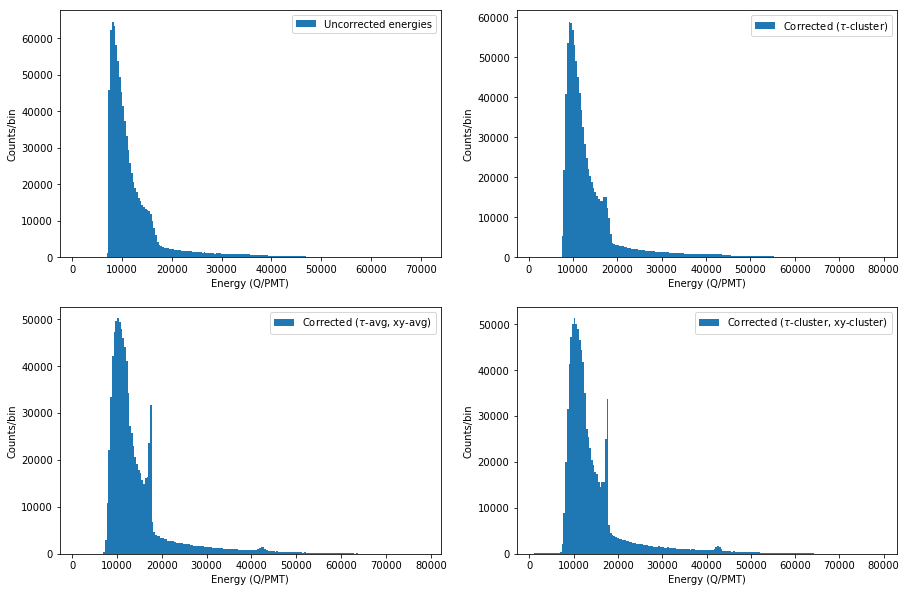

In [7]:
cuts_espectra = C_basic
print(A_Ec_avg)
ebins = 200

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(A_E0[cuts_espectra]/npmts,bins=ebins,label='Uncorrected energies')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(A_Ec_tau[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-cluster)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(A_Ec_avg[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-avg, xy-avg)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(A_Ec[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-cluster, xy-cluster)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

## Radial and z distributions

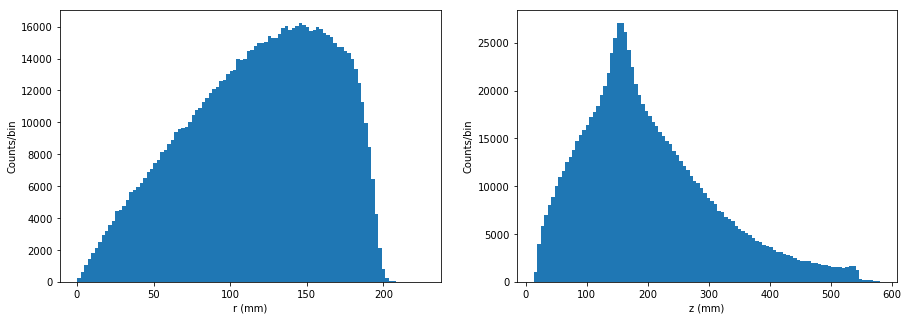

In [8]:
# Distributions in r and z
cuts_rz = C_basic


fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# event distribution in R
ax1 = fig.add_subplot(121);
plt.hist(A_ravg[cuts_rz],bins=100)
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

# event distribution in z
ax2 = fig.add_subplot(122);
plt.hist(A_zavg[cuts_rz],bins=100)
plt.xlabel('z (mm)')
plt.ylabel('Counts/bin')

## x-y distribution

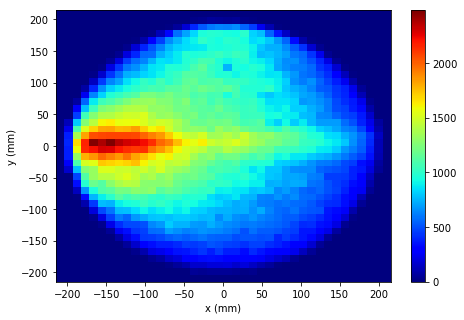

In [9]:
# Distribution in x-y
cuts_xy = C_basic
nxybins = 40

fig = plt.figure(1);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# correction factor
plt.hist2d(A_xavg[cuts_xy], A_yavg[cuts_xy], (nxybins, nxybins), ((-215, 215), (-215, 215)), cmap='jet')
plt.colorbar()
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

## Energy spectrum (double-escape peak)

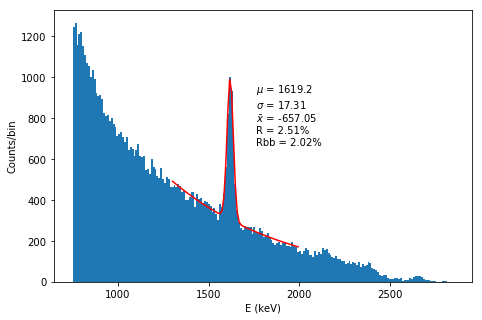

In [10]:
# Energy spectrum, focusing on double-escape peak
cuts_espec = C_wide

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y0, x0, _ = plt.hist(A_Ec[cuts_espec]*CAL_FACTOR, 200, range=[750,2850])

# Gaussian + exponential fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, 1300, 2000)
x, y = x[sel], y0[sel]
f    = fitf.fit(gaussexpo, x, y, (200, 1600, 100, 20, -600, 1200))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))

# Gaussian fit
#f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
#plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

# Energy spectrum (Cs 662 keV peak)

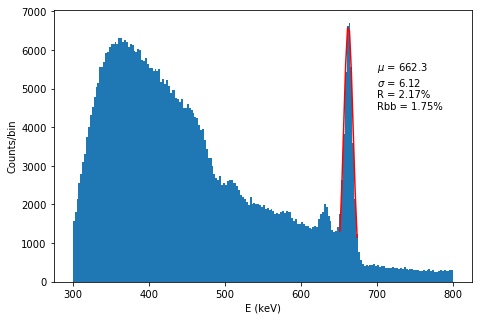

In [11]:
# Energy spectrum, focusing on Cs peak
cuts_espec = C_wide

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y0, x0, _ = plt.hist(A_Ec[cuts_espec]*CAL_FACTOR, 200, range=[300,800])

# Gaussian + exponential fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, 650, 675)
x, y = x[sel], y0[sel]
f    = fitf.fit(fitf.gauss, x, y, (120, 640, 10))
plt.plot(x, f.fn(x), "r")
#plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))

# Gaussian fit
plt.text(700, 4*max(y)/6, gausstext(f.values))

plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

## Energy spectrum (2.6 MeV peak)

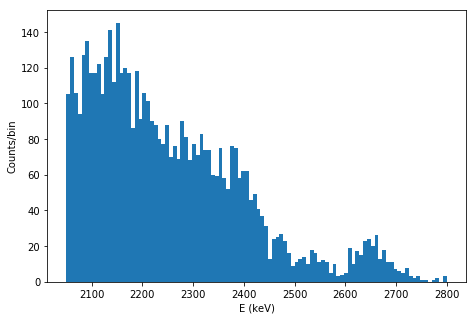

In [12]:
# Energy spectrum, focusing on 2.6 MeV peak
cuts_peak2pt6 = C_basic

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y, x, _ = plt.hist(A_Ec[cuts_peak2pt6]*CAL_FACTOR, 100, range=[2050,2800])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

## Time evolution of energy

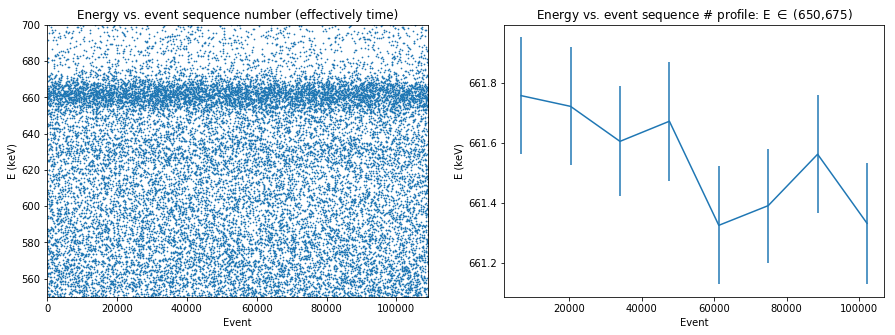

In [13]:
# Energy vs. event (effectively "time")
cuts_time = C_basic

Ehist_min = 650
Ehist_max = 675
enseq = np.array(range(len(A_Ec[cuts_time])))
tprof, Eprof, Eerr = fitf.profileX(enseq,A_Ec[cuts_time]*CAL_FACTOR,nbins=8,xrange=(0,109000),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
ax1.scatter(enseq,A_Ec[cuts_time]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. event sequence number (effectively time)")
plt.ylim([550,700])
plt.xlim([0,109000])
plt.xlabel('Event')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122)
ax2.errorbar(tprof,Eprof,yerr=Eerr)
plt.title("Energy vs. event sequence # profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('Event')
plt.ylabel('E (keV)')

## Energy as a function of z

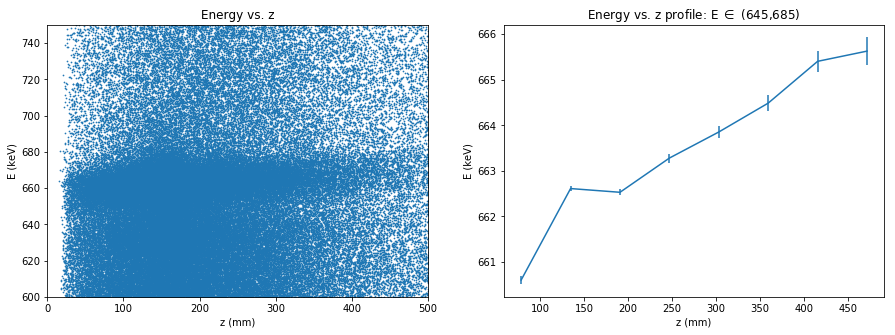

In [14]:
# Energy vs. z
cuts_z = C_basic

Ehist_min = 645
Ehist_max = 685
zprof, Eprof, Eerr = fitf.profileX(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,nbins=8,xrange=(50,500),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. z")
plt.ylim([600,750])
plt.xlim([0,500])
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122);
ax2.errorbar(zprof,Eprof,yerr=Eerr)
plt.title("Energy vs. z profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

## Energy as a function of r

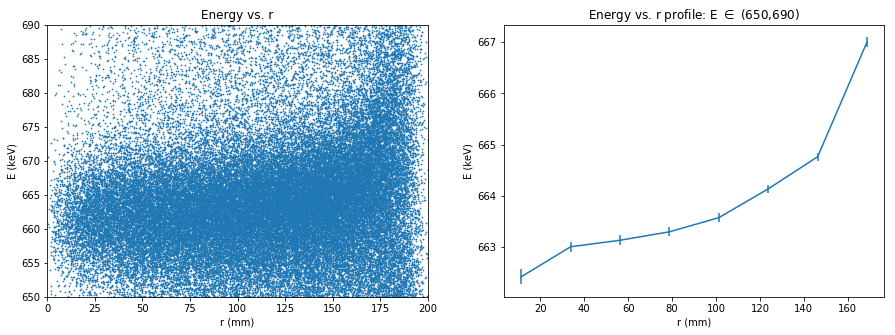

In [15]:
# Energy vs. z
cuts_r = C_basic

Ehist_min = 650
Ehist_max = 690
rprof, Eprof, Eerr = fitf.profileX(A_ravg[cuts_r],A_Ec[cuts_r]*CAL_FACTOR,nbins=8,xrange=(0,180),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(A_ravg[cuts_r],A_Ec[cuts_r]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. r")
plt.ylim([650,690])
plt.xlim([0,200])
plt.xlabel('r (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122);
ax2.errorbar(rprof,Eprof,yerr=Eerr)
plt.title("Energy vs. r profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('r (mm)')
plt.ylabel('E (keV)')

-----------------------

---------------------